
Data starting from the last valid date:
        Date  ClimDiv  USCRN
0 1895-01-01    -5.66 -99.99
1 1895-02-01    -9.05 -99.99
2 1895-03-01    -3.60 -99.99
3 1895-04-01     1.05 -99.99
4 1895-05-01    -1.12 -99.99

Basic Statistics for filtered data:
                                Date      ClimDiv        USCRN
count                           1553  1553.000000  1553.000000
mean   1959-08-31 23:09:00.115904704    -0.991958   -84.928307
min              1895-01-01 00:00:00   -10.450000   -99.990000
25%              1927-05-01 00:00:00    -2.140000   -99.990000
50%              1959-09-01 00:00:00    -0.850000   -99.990000
75%              1992-01-01 00:00:00     0.380000   -99.990000
max              2024-05-01 00:00:00     6.840000     6.930000
std                              NaN     2.236320    35.869436


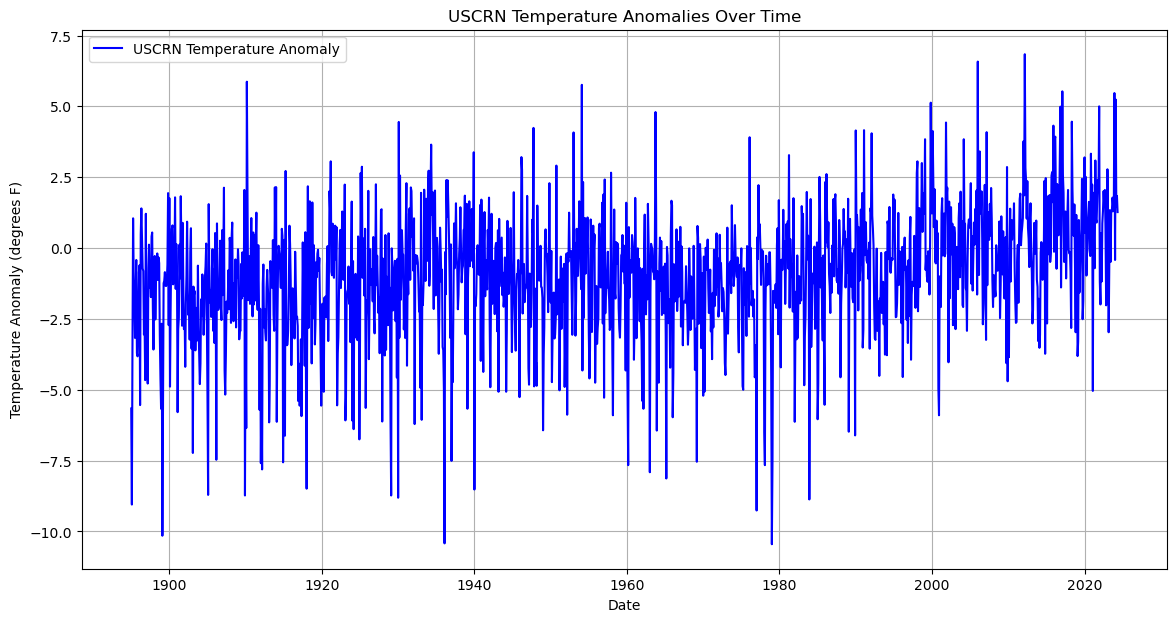

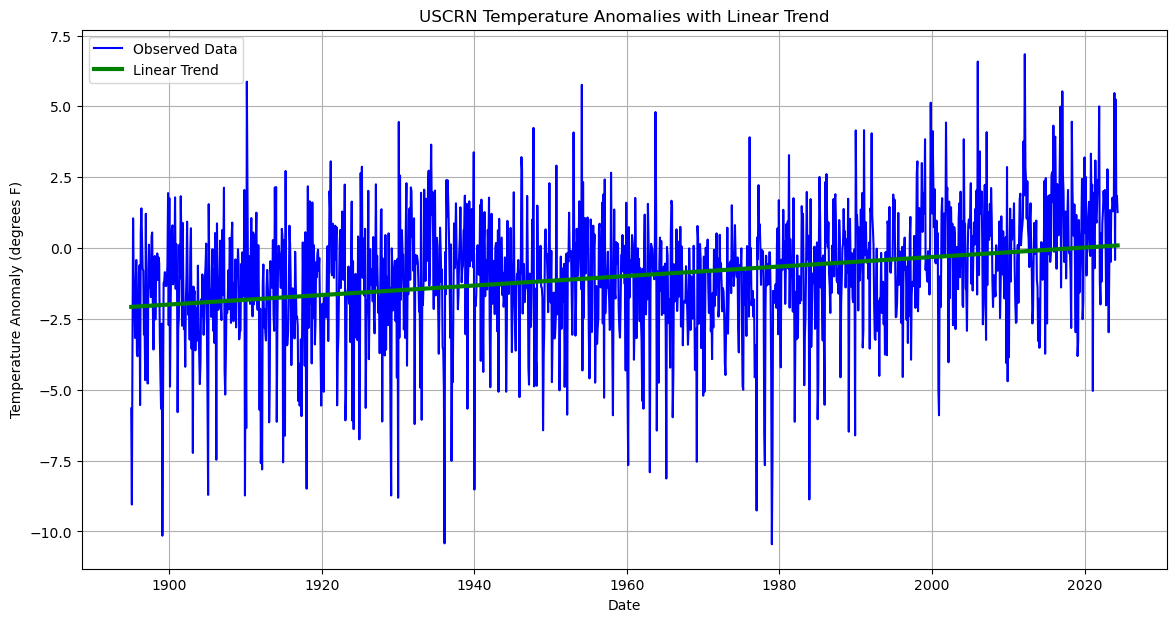

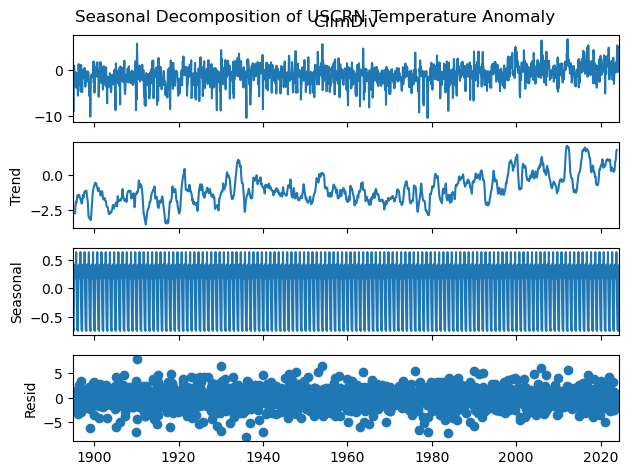

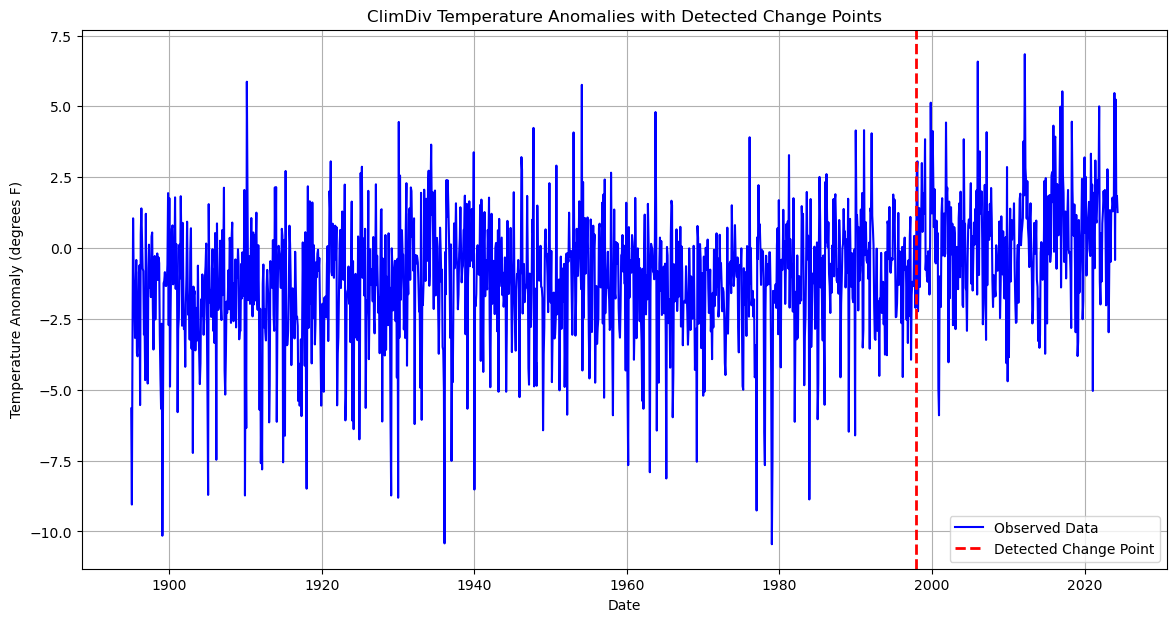

IndexError: index 1553 is out of bounds for axis 0 with size 1553

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import ruptures as rpt

# Step 1: Load the Data from the URL
url = "https://www.ncei.noaa.gov/access/monitoring/national-temperature-index/time-series/anom-tavg/1/0/data.csv"
data = pd.read_csv(url, skiprows=1)  # Skip the first descriptive row

# Rename columns according to the provided structure
data.columns = ['Date', 'ClimDiv', 'USCRN']
c='ClimDiv'

# Convert 'Date' to a datetime format assuming 'YYYYMM' format
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m')

# Convert 'USCRN' to numeric and filter out invalid values (-99.99 or -9999)
data[c] = pd.to_numeric(data[c], errors='coerce')
filtered_data = data[data[c] != -99.99]


# Start analysis from the last valid date
last_valid_date = filtered_data['Date'].min()
filtered_data = filtered_data[filtered_data['Date'] >= last_valid_date]

# Display the first few rows after starting from the last valid date
print("\nData starting from the last valid date:")
print(filtered_data.head())

# Step 2: Basic Exploration
print("\nBasic Statistics for filtered data:")
print(filtered_data.describe())

# Step 3: Time Series Analysis
ts = filtered_data.set_index('Date')[c]

# Plot the time series data
plt.figure(figsize=(14, 7))
plt.plot(ts, label='USCRN Temperature Anomaly', color='blue')
plt.title('USCRN Temperature Anomalies Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (degrees F)')
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Trend Analysis
# Fit a linear regression model to the entire filtered data
observed_dates = ts.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
observed_temp = ts.values

lr_observed = LinearRegression()
lr_observed.fit(observed_dates, observed_temp)
observed_trend = lr_observed.predict(observed_dates)

# Plot the observed data with linear trend
plt.figure(figsize=(14, 7))
plt.plot(ts.index, ts.values, label='Observed Data', color='blue')
plt.plot(ts.index, observed_trend, label='Linear Trend', color='green', linewidth=3)
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (degrees F)')
plt.title('USCRN Temperature Anomalies with Linear Trend')
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Seasonal Decomposition
decomposition = seasonal_decompose(ts.dropna(), model='additive', period=12)
decomposition.plot()
plt.suptitle('Seasonal Decomposition of USCRN Temperature Anomaly')
plt.show()

# Step 6: Change Point Detection
# Use the Pelt method to detect change points
algo = rpt.Pelt(model="rbf").fit(ts.dropna().values)
penalty = 10
result = algo.predict(pen=penalty)

# Plot the data with detected change points
plt.figure(figsize=(14, 7))
plt.plot(ts.index, ts.values, label='Observed Data', color='blue')
for cp in result[:-1]:  # Exclude the last point which is the end of the data
    plt.axvline(x=ts.index[cp], color='red', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (degrees F)')
plt.title(c+' Temperature Anomalies with Detected Change Points')
plt.legend(['Observed Data', 'Detected Change Point'])
plt.grid(True)
plt.show()

# Step 7: Segment Analysis
# Calculate means for segments defined by the change points
if len(result) > 1:
    mean_before_cp = ts[:ts.index[result[0]]].mean()
    mean_between_cp = ts[ts.index[result[0]]:ts.index[result[1]]].mean()
    mean_after_cp = ts[ts.index[result[1]]:].mean()

    print(f"Mean before first change point ({ts.index[result[0]]}): {mean_before_cp:.2f}")
    print(f"Mean between change points ({ts.index[result[0]]} - {ts.index[result[1]]}): {mean_between_cp:.2f}")
    print(f"Mean after second change point ({ts.index[result[1]]}): {mean_after_cp:.2f}")

    # Plot the segments with their mean values
    plt.figure(figsize=(14, 7))
    plt.plot(ts.index, ts.values, label='Observed Data', color='blue')
    plt.hlines(mean_before_cp, ts.index[0], ts.index[result[0]], colors='green', linestyles='dashed', linewidth=3, label='Mean Before First CP')
    plt.hlines(mean_between_cp, ts.index[result[0]], ts.index[result[1]], colors='orange', linestyles='dashed', linewidth=3, label='Mean Between CPs')
    plt.hlines(mean_after_cp, ts.index[result[1]], ts.index[-1], colors='red', linestyles='dashed', linewidth=3, label='Mean After Second CP')
    plt.xlabel('Date')
    plt.ylabel('Temperature Anomaly (degrees F)')
    plt.title(c+""+ 'Temperature Anomalies with Segment Means and Change Points')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No significant change points detected.")



Data starting from the first valid date:
        Date  ClimDiv  USCRN
0 1895-01-01    -5.66 -99.99
1 1895-02-01    -9.05 -99.99
2 1895-03-01    -3.60 -99.99
3 1895-04-01     1.05 -99.99
4 1895-05-01    -1.12 -99.99

Basic Statistics for filtered data:
                                Date      ClimDiv        USCRN
count                           1553  1553.000000  1553.000000
mean   1959-08-31 23:09:00.115904704    -0.991958   -84.928307
min              1895-01-01 00:00:00   -10.450000   -99.990000
25%              1927-05-01 00:00:00    -2.140000   -99.990000
50%              1959-09-01 00:00:00    -0.850000   -99.990000
75%              1992-01-01 00:00:00     0.380000   -99.990000
max              2024-05-01 00:00:00     6.840000     6.930000
std                              NaN     2.236320    35.869436


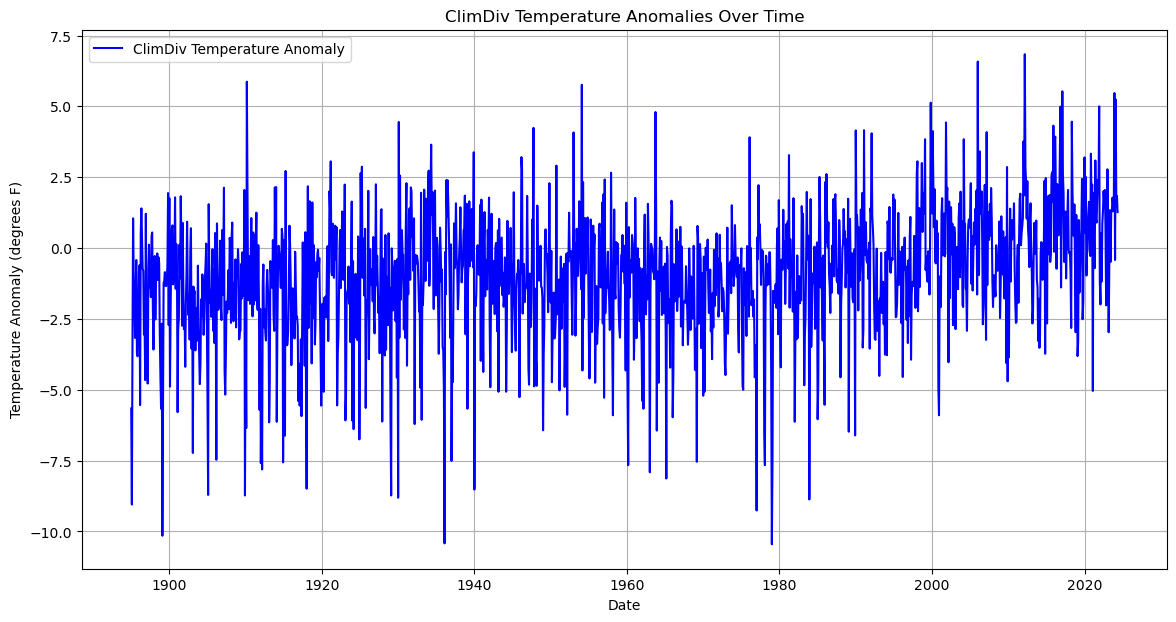

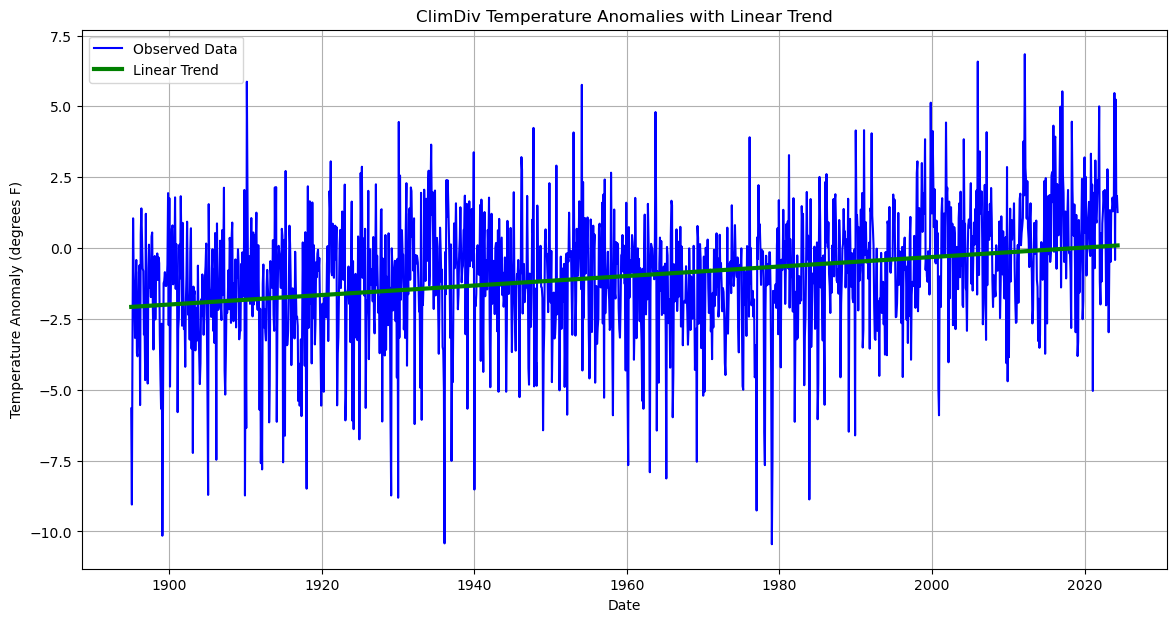

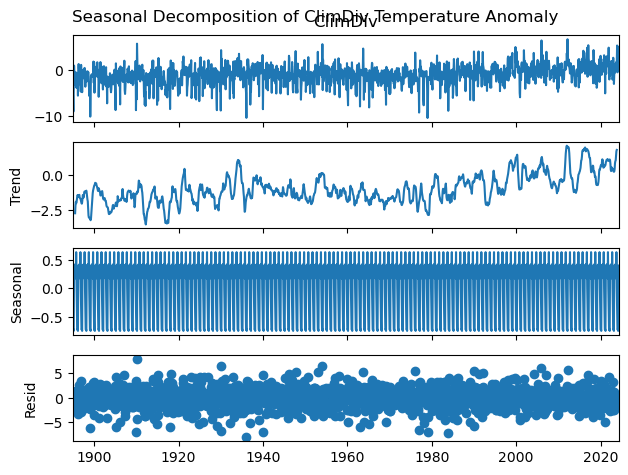

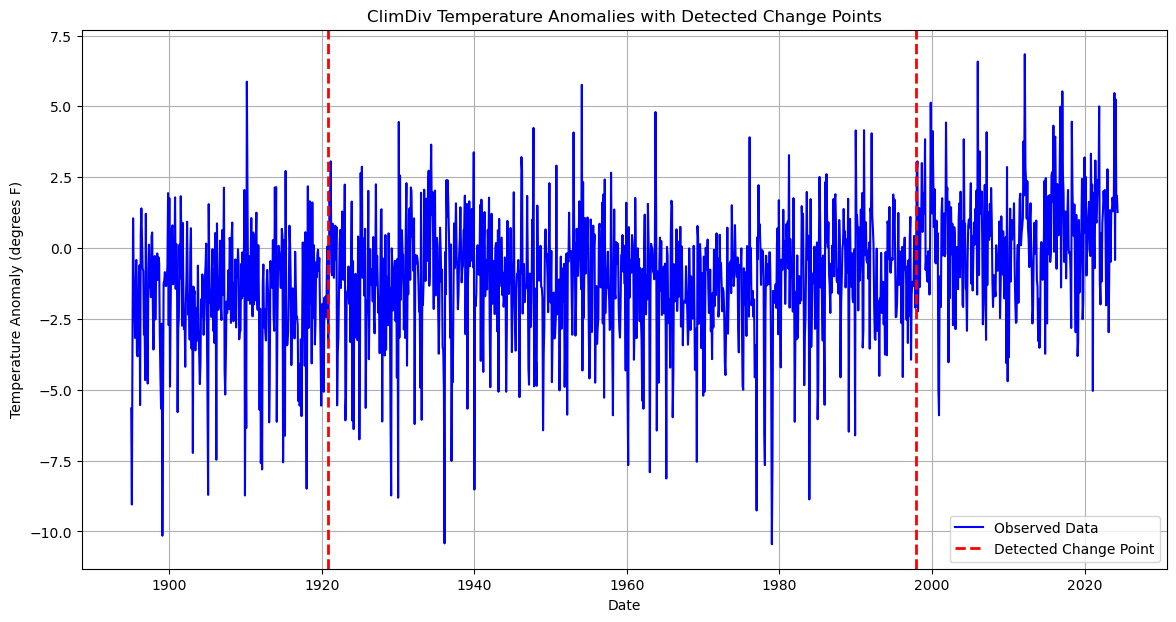

Mean before first change point (1920-11-01 00:00:00): -1.86
Mean between change points (1920-11-01 00:00:00 - 1997-12-01 00:00:00): -1.17
Mean after second change point (1997-12-01 00:00:00): 0.36


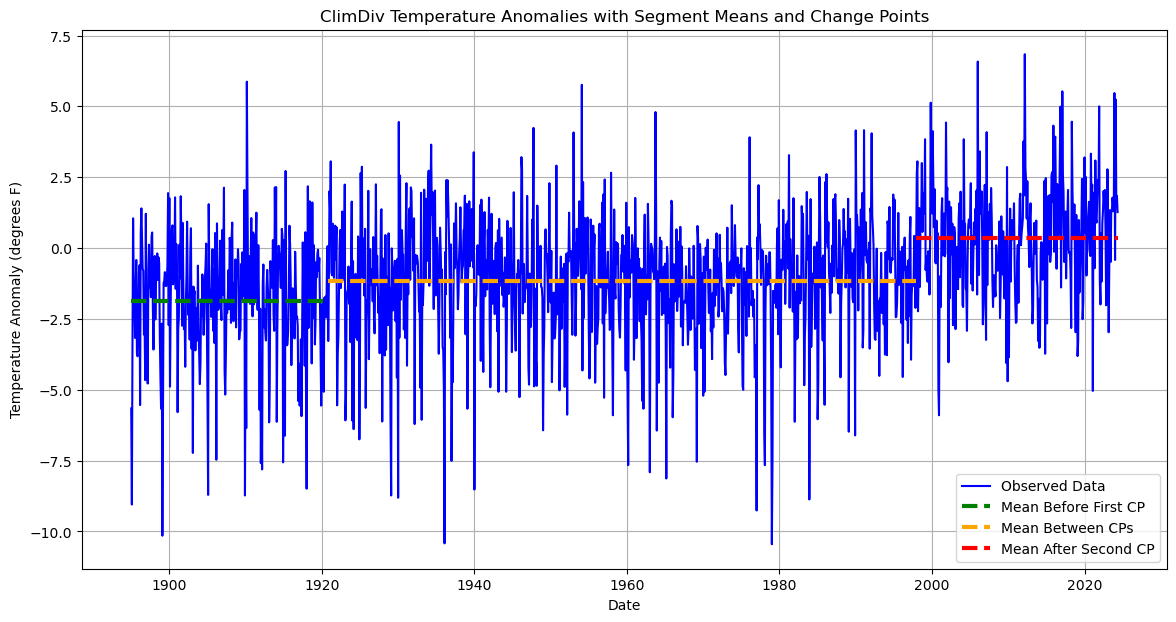

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import ruptures as rpt

# Step 1: Load the Data from the URL
url = "https://www.ncei.noaa.gov/access/monitoring/national-temperature-index/time-series/anom-tavg/1/0/data.csv"
data = pd.read_csv(url, skiprows=1)  # Skip the first descriptive row

# Rename columns according to the provided structure
data.columns = ['Date', 'ClimDiv', 'USCRN']
c = 'ClimDiv'  # Column to analyze

# Convert 'Date' to a datetime format assuming 'YYYYMM' format
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m')

# Convert 'ClimDiv' to numeric and filter out invalid values (-99.99 or -9999)
data[c] = pd.to_numeric(data[c], errors='coerce')
filtered_data = data[data[c] != -99.99]

# Start analysis from the first valid date
first_valid_date = filtered_data['Date'].min()
filtered_data = filtered_data[filtered_data['Date'] >= first_valid_date]

# Display the first few rows after starting from the first valid date
print("\nData starting from the first valid date:")
print(filtered_data.head())

# Step 2: Basic Exploration
print("\nBasic Statistics for filtered data:")
print(filtered_data.describe())

# Step 3: Time Series Analysis
ts = filtered_data.set_index('Date')[c]

# Plot the time series data
plt.figure(figsize=(14, 7))
plt.plot(ts, label=f'{c} Temperature Anomaly', color='blue')
plt.title(f'{c} Temperature Anomalies Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (degrees F)')
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Trend Analysis
# Fit a linear regression model to the entire filtered data
observed_dates = ts.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
observed_temp = ts.values

lr_observed = LinearRegression()
lr_observed.fit(observed_dates, observed_temp)
observed_trend = lr_observed.predict(observed_dates)

# Plot the observed data with linear trend
plt.figure(figsize=(14, 7))
plt.plot(ts.index, ts.values, label='Observed Data', color='blue')
plt.plot(ts.index, observed_trend, label='Linear Trend', color='green', linewidth=3)
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (degrees F)')
plt.title(f'{c} Temperature Anomalies with Linear Trend')
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Seasonal Decomposition
decomposition = seasonal_decompose(ts.dropna(), model='additive', period=12)
decomposition.plot()
plt.suptitle(f'Seasonal Decomposition of {c} Temperature Anomaly')
plt.show()

# Step 6: Change Point Detection
# Use the Pelt method to detect change points
algo = rpt.Pelt(model="rbf").fit(ts.dropna().values)
penalty = 5
result = algo.predict(pen=penalty)

# Plot the data with detected change points
plt.figure(figsize=(14, 7))
plt.plot(ts, label='Observed Data', color='blue')
for cp in result[:-1]:  # Exclude the last point which is the end of the data
    if cp < len(ts):  # Ensure the change point index is valid
        plt.axvline(x=ts.index[cp], color='red', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (degrees F)')
plt.title(f'{c} Temperature Anomalies with Detected Change Points')
plt.legend(['Observed Data', 'Detected Change Point'])
plt.grid(True)
plt.show()

# Step 7: Segment Analysis
# Calculate means for segments defined by the change points
if len(result) > 1:
    # Ensure indices are within valid range
    valid_results = [cp for cp in result if cp < len(ts)]
    if len(valid_results) > 1:
        mean_before_cp = ts[:ts.index[valid_results[0]]].mean()
        mean_between_cp = ts[ts.index[valid_results[0]]:ts.index[valid_results[1]]].mean()
        mean_after_cp = ts[ts.index[valid_results[1]]:].mean()

        print(f"Mean before first change point ({ts.index[valid_results[0]]}): {mean_before_cp:.2f}")
        print(f"Mean between change points ({ts.index[valid_results[0]]} - {ts.index[valid_results[1]]}): {mean_between_cp:.2f}")
        print(f"Mean after second change point ({ts.index[valid_results[1]]}): {mean_after_cp:.2f}")

        # Plot the segments with their mean values
        plt.figure(figsize=(14, 7))
        plt.plot(ts.index, ts.values, label='Observed Data', color='blue')
        plt.hlines(mean_before_cp, ts.index[0], ts.index[valid_results[0]], colors='green', linestyles='dashed', linewidth=3, label='Mean Before First CP')
        plt.hlines(mean_between_cp, ts.index[valid_results[0]], ts.index[valid_results[1]], colors='orange', linestyles='dashed', linewidth=3, label='Mean Between CPs')
        plt.hlines(mean_after_cp, ts.index[valid_results[1]], ts.index[-1], colors='red', linestyles='dashed', linewidth=3, label='Mean After Second CP')
        plt.xlabel('Date')
        plt.ylabel('Temperature Anomaly (degrees F)')
        plt.title(f'{c} Temperature Anomalies with Segment Means and Change Points')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("No significant change points detected.")
